# <center> Modélisation

Dans cette section, nous cherchons à prédire la gravité de l'accident grâce aux variables explicatives telles que le type de la collision, le type de la route, la luminosité, etc. \
Pour cela, notre variable cible s'appelle "gravite", elle vaut 1 si lors de l'accident, il y a eu au moins un blessé hospitalisé et/ou une personne tuée et elle vaut 0 sinon (les usagers sont soit indemnes, soit des blessés légers).

In [1]:
%run "./Ouverture_donnees.ipynb"

Les importations nécessaires à la modélisation : 

In [2]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import svm
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn import tree

In [81]:
#df_accidents.columns

## Préparation des données

Pour une meilleure modélisation, il est essentiel d'avoir un nombre de modalités raisonnable. Ainsi, nous regroupons les modalités ensemble si elles correspondent à un pourcentage d'accidents graves proche.

In [3]:
# Mettre des modalités ensemble :
df_accidents["collision"] = df_accidents["collision"].replace(["2 - frontale", "2-arriere", "3 vehicules", "2-cote"], "2 ou 3 véhicules")

df_accidents["catr"] = df_accidents["catr"].replace(["Route départementale", "Route nationale", "Autre"], "Route départementale ou nationale + Autre")
df_accidents["catr"] = df_accidents["catr"].replace(["Autoroute", "Voie Communale"], "Autoroute + Voie Communale")

df_accidents["lum"] = df_accidents["lum"].replace(["Crépuscule ou aube"], "Plein jour")

## Sélection de variables
Dans un premier temps, on étudie le pouvoir prédictif des variables explicatives. \
Le V de Cramer mesure l'association entre la variable explicative et la variable cible "gravité". On a réalisé un test d'indépendance du Chi-2. Si la p-valeur est inférieur à 0.05, alors l'hypothèse nulle d'indépendance est rejetée et il existe une dépendance entre la variable explicative et la variable cible. \
On retrouve ci-dessous les différentes valeurs de V de Cramer et de p-valeurs.

In [4]:
colonne = ["agglo", "lum", "int", "collision", "atm", "catr", "circ", "surf", "prof", "plan", "infra", "situ"]

def cramers(df):
    L_cramer = []
    L_pvalue = []
    L_var = []
    for elem in colonne :
        crosstab = pd.crosstab(df[elem], df.gravite, margins = True, normalize = 'index')*100
        chi2 = ss.chi2_contingency(crosstab)[0]
        p_value = round(ss.chi2_contingency(crosstab)[1], 3)
        n = sum(crosstab.sum())
        VCramer = round(np.sqrt(chi2 / (n*(min(crosstab.shape)-1))), 3)
        L_cramer.append(VCramer)
        L_pvalue.append(p_value)
        L_var.append(elem)
    tableau = np.array([L_cramer, L_pvalue])
    pd_tableau = pd.DataFrame(tableau.T, index = L_var, columns = ['V de Cramer', 'p_value'])
    return pd_tableau.sort_values("p_value")

cramers(df_accidents)

,V de Cramer,p_value
situ,0.288,0.000
agglo,0.209,0.001
catr,0.221,0.001
circ,0.200,0.001
lum,0.191,0.002
plan,0.151,0.032
collision,0.139,0.051
prof,0.095,0.261
atm,0.080,0.465
int,0.072,0.552


Ainsi, les variables utilisées seront Catr (le type de route), Situ (lieu de l'accident), Agglo (si l'accident a lieu en agglomération), Circ (le sens de circulation), Lum (la lminosité), plan (si la route est rectiligne ou courbée) et collision.

Créer les indicatrices nécessaires

In [5]:
# Variable cible :
df_accidents["y"] = (df_accidents["gravite"]==2).astype(int)


# Variables explicatives :
df_accidents["Sans collision"] = pd.get_dummies(df_accidents["collision"])["Sans collision"]
df_accidents["Autre collision"] = pd.get_dummies(df_accidents["collision"])["autre"]

df_accidents["Route dep ou nationale"] = pd.get_dummies(df_accidents["catr"])["Route départementale ou nationale + Autre"]

df_accidents["Sur accotement"] = pd.get_dummies(df_accidents["situ"])["Sur accotement"]
df_accidents["Autre lieu de l'accident"] = pd.get_dummies(df_accidents["situ"])["Autre"]

df_accidents["Hors agglomeration"] = pd.get_dummies(df_accidents["agglo"])["Hors agglomeration"]

df_accidents["A chaussées séparées"] = pd.get_dummies(df_accidents["circ"])["A chaussées séparées"]
df_accidents["Bidirectionnelle"] = pd.get_dummies(df_accidents["circ"])["Bidirectionnelle"]

df_accidents["Nuit sans éclairage"] = pd.get_dummies(df_accidents["lum"])["Nuit sans éclairage public"]
df_accidents["Plein jour"] = pd.get_dummies(df_accidents["lum"])["Plein jour"]

df_accidents["Courbe"] = pd.get_dummies(df_accidents["plan"])["Courbe"]

In [85]:
#data = pd.get_dummies(df_accidents[col],drop_first=True)

Créer les échantillons de test et d'apprentissage

In [6]:
# Les variables explicatives sous forme d'indicatrices
col = ["Route dep ou nationale", "Sur accotement", "Autre lieu de l'accident", "Hors agglomeration",
       "A chaussées séparées", "Bidirectionnelle", "Nuit sans éclairage", "Plein jour",
       "Sans collision", "Autre collision", "Courbe"]

# Créer de la base de donner avec uniquement les variables explicatives
df_temp = df_accidents[col]

# Création des échantillons de test et d'apprentissage
xTrain, xTest, yTrain, yTest = train_test_split(df_temp, df_accidents["y"].values.ravel(), test_size = 0.2, random_state = 0)

## Modélisation et performance du modèle

Nous allons étudier différents types de modèles :
* Classification
* Régression linéaire
* Arbre de décision

Pour cela, nous codons des fonctions pour tracer les courbes ROC et les matrices de confusion.

### Fonctions utiles

In [130]:
def courbe_roc(modele, prob_pred, y) :
    prob_sans_modele = [0 for _ in range(len(y))]
    
    # calculate scores
    auc_sans_modele = roc_auc_score(yTest, prob_sans_modele)
    auc = roc_auc_score(yTest, prob_pred)
    # summarize scores
    print('Modèle aléatoire : ROC AUC=%.3f' % (auc_sans_modele))
    print('Modèle : ROC AUC=%.3f' % (auc))
    # calculate roc curves
    fpr_sans_modele, tpr_sans_modele, _ = roc_curve(y, prob_sans_modele)
    fpr, tpr, _ = roc_curve(yTest, prob_pred)
    # plot the roc curve for the model
    plt.plot(fpr_sans_modele, tpr_sans_modele, linestyle='--', label='Modèle aléatoire')
    plt.plot(fpr, tpr, label='Modèle')
    # axis labels
    plt.xlabel('Taux de vrais positifs')
    plt.ylabel('Taux de faux positifs')
    # show the legend
    plt.legend()
    # show the plot
    plt.show() 

In [131]:
#Fonction servant à comparer graphiquement les courbes ROC de différents modèles de classification
def courbe_roc_synthese(modele1,modele2,modele3,modele4) :
    prob_sans_modele = [0 for _ in range(len(yTest))]
    # predict probabilities
    prob_pred1 = modele1.predict_proba(xTest)
    prob_pred2 = modele2.predict_proba(xTest)
    prob_pred3 = modele3.predict_proba(xTest)
    prob_pred4 = modele4.predict_proba(xTest)
    # keep probabilities for the positive outcome only
    prob_pred1 = prob_pred1[:, 1]
    prob_pred2 = prob_pred2[:, 1]
    prob_pred3 = prob_pred3[:, 1]
    prob_pred4 = prob_pred4[:, 1]
    # calculate scores
    auc_sans_modele = roc_auc_score(yTest, prob_sans_modele)
    auc1 = roc_auc_score(yTest, prob_pred1)
    auc2 = roc_auc_score(yTest, prob_pred2)
    auc3 = roc_auc_score(yTest, prob_pred3)
    auc4 = roc_auc_score(yTest, prob_pred4)
    # summarize scores
    print('Modèle aléatoire : ROC AUC=%.3f' % (auc_sans_modele))
    print('Modèle SVC : ROC AUC=%.3f' % (auc1))
    print('Modèle SGD : ROC AUC=%.3f' % (auc2))
    print('Modèle KNN : ROC AUC=%.3f' % (auc3))
    print('Modèle Dtree: ROC AUC=%.3f' % (auc4))
    # calculate roc curves
    fpr_sans_modele, tpr_sans_modele, _ = roc_curve(yTest, prob_sans_modele)
    fpr1, tpr1, _ = roc_curve(yTest, prob_pred1)
    fpr2, tpr2, _ = roc_curve(yTest, prob_pred2)
    fpr3, tpr3, _ = roc_curve(yTest, prob_pred3)
    fpr4, tpr4, _ = roc_curve(yTest, prob_pred4)
    # plot the roc curve for the model
    plt.plot(fpr_sans_modele, tpr_sans_modele, linestyle='--', label='Modèle aléatoire')
    plt.plot(fpr1, tpr1, label='Modèle SVC')
    plt.plot(fpr2, tpr2, label='Modèle SGD')
    plt.plot(fpr3, tpr3, label='Modèle KNN')
    plt.plot(fpr4, tpr4, label='Modèle DTree')
    # axis labels
    plt.xlabel('Taux de vrais positifs')
    plt.ylabel('Taux de faux positifs')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [132]:
def courbe_roc_synthese_bis(liste_modele, nom_modele) :
    prob_sans_modele = [0 for _ in range(len(yTest))]
    # predict probabilities
    liste_prob_pred = []
    for modele in liste_modele :
        prob_pred = modele.predict_proba(xTest)[:, 1]
        liste_prob_pred.append(prob_pred)
        
    pred_regression_logistique = modele_logistique.predict(sm.tools.add_constant(xTest))
    liste_prob_pred.append(pred_regression_logistique)
    nom_modele.append("Régression logistique")
    
    # calculate scores
    auc_sans_modele = roc_auc_score(yTest, prob_sans_modele)
    auc = []
    for prob_pred in liste_prob_pred :
        auc.append(roc_auc_score(yTest, prob_pred))
        
    # summarize scores
    print('Modèle aléatoire : ROC AUC=%.3f' % (auc_sans_modele))
    for i in range(len(auc)) :
        print('Modèle ' + nom_modele[i] +' : ROC AUC=%.3f' % (auc[i]))

    # calculate roc curves
    fpr_sans_modele, tpr_sans_modele, _ = roc_curve(yTest, prob_sans_modele)
    
    fpr = []
    tpr = []
    
    for prob_pred in liste_prob_pred :
        fpr.append(roc_curve(yTest, prob_pred)[0])
        tpr.append(roc_curve(yTest, prob_pred)[1])

    # plot the roc curve for the model
    plt.plot(fpr_sans_modele, tpr_sans_modele, linestyle='--', label='Modèle aléatoire')
    for i in range(len(fpr)) :
        plt.plot(fpr[i], tpr[i], label = nom_modele[i])
    
    
    
    # axis labels
    plt.xlabel('Taux de vrais positifs')
    plt.ylabel('Taux de faux positifs')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [9]:
def matrice_confusion(modele) :
    sklearn.metrics.plot_confusion_matrix(modele, xTest, yTest)
    plt.show()

### Classification

Nous testons les modèles de classification suivants:
- Linear SVC
- SGD Classifier
- KNeighbors Classifier  

pour déterminer celui le plus précis et le plus adapté à notre base de données

###### 1. Modèle Linear SVC

Entrainement d'un classifieur SVM avec comme paramètre de régularisation C=1

In [22]:
classification_SVC = svm.SVC(kernel='linear', C=1, probability = True).fit(xTrain, yTrain)
y_pred = classification_SVC.predict(xTest)

Calcul des indicateurs

In [23]:
sc_accuracy_SVC = sklearn.metrics.accuracy_score(y_pred, yTest)
sc_precision_SVC = sklearn.metrics.precision_score(y_pred, yTest)
sc_recall_SVC = sklearn.metrics.recall_score(y_pred, yTest)
sc_f1_SVC = sklearn.metrics.f1_score(y_pred, yTest)
print(sc_accuracy_SVC)
print(sc_precision_SVC)
print(sc_recall_SVC)
print(sc_f1_SVC)

0.7164709517923362
0.44371561574269996
0.6682600382409177
0.5333163784333673


Tracé de la courbe ROC

Modèle aléatoire : ROC AUC=0.500
Modèle : ROC AUC=0.724


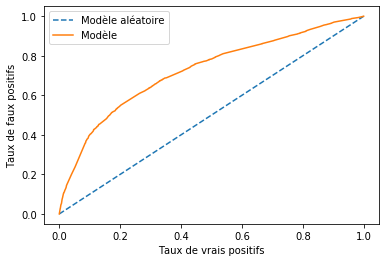

In [39]:
prob_pred = classification_SVC.predict_proba(xTest)[:, 1]
courbe_roc(classification_SVC, prob_pred, yTest)

Détermination de la matrice de confusion

/Users/camille/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


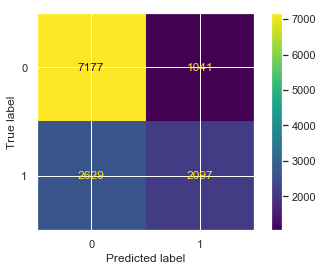

In [93]:
matrice_confusion(classification_SVC)

Ainsi, si la mesure de précision (0.72) et la courbe ROC sont plutôt satisfaisantes, la F-mesure (0.53) pourrait être améliorée et la matrice de confusion montre une proportion de faux négatifs assez élevée.

###### 2. Modèle SGD Classifier

Entrainement d'un classifieur SGD, avec calibrement du classifieur afin de calculer les probabilités des valeurs, nécessaires au tracé de la courbe ROC

In [10]:
classification_SGD = SGDClassifier(max_iter=1000, tol=0.001)
calibrated_classification_SGD = CalibratedClassifierCV(classification_SGD, cv=5, method='sigmoid').fit(xTrain,yTrain)
y_pred = calibrated_classification_SGD.predict(xTest)

Calcul des indicateurs

In [11]:
sc_accuracy_SGD = sklearn.metrics.accuracy_score(y_pred, yTest)
sc_precision_SGD = sklearn.metrics.precision_score(y_pred, yTest)
sc_recall_SGD = sklearn.metrics.recall_score(y_pred, yTest)
sc_f1_SGD = sklearn.metrics.f1_score(y_pred, yTest)
print(sc_accuracy_SGD)
print(sc_f1_SGD)
print(sc_recall_SGD)
print(sc_precision_SGD)

0.7195611866501854
0.5227452011569813
0.6902777777777778
0.4206517139229793


Tracé de la courbe ROC

Modèle aléatoire : ROC AUC=0.500
Modèle : ROC AUC=0.725


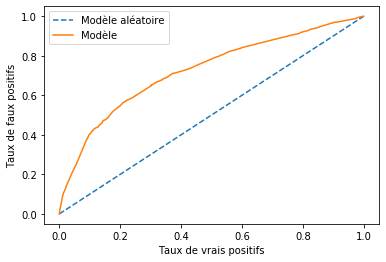

In [37]:
prob_pred = calibrated_classification_SGD.predict_proba(xTest)[:, 1]
courbe_roc(calibrated_classification_SGD, prob_pred, yTest)

Détermination de la matrice de confusion

/Users/camille/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


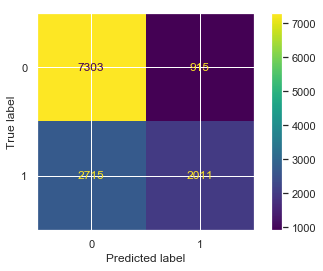

In [97]:
matrice_confusion(calibrated_classification_SGD)

Ainsi, comme le modèle Linear SVC, la mesure de précision (0.72) et la courbe ROC sont plutôt satisfaisantes mais la F-mesure (0.42) pourrait être améliorée. La matrice de confusion montre également une proportion de faux négatifs assez élevée.

###### 3. Modèle KNeighbors Classifier

Entrainement d'un classifieur KNeighbors

In [13]:
classification_KNN = KNeighborsClassifier(n_neighbors = 5).fit(xTrain,yTrain)
y_pred = classification_KNN.predict(xTest)

Calcul des indicateurs

In [14]:
sc_accuracy_KNN = sklearn.metrics.accuracy_score(y_pred, yTest)
sc_precision_KNN = sklearn.metrics.precision_score(y_pred, yTest)
sc_recall_KNN = sklearn.metrics.recall_score(y_pred, yTest)
sc_f1_KNN = sklearn.metrics.f1_score(y_pred, yTest)
print(sc_accuracy_KNN)
print(sc_precision_KNN)
print(sc_recall_KNN)
print(sc_f1_KNN)

0.6736711990111248
0.32331781633516715
0.5982772122161315
0.4197802197802198


Tracé de la courbe ROC

Modèle aléatoire : ROC AUC=0.500
Modèle : ROC AUC=0.622


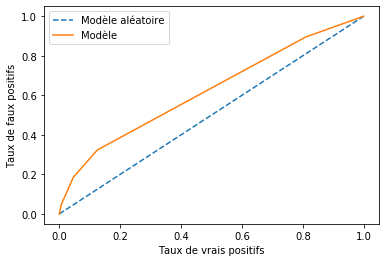

In [40]:
prob_pred = classification_KNN.predict_proba(xTest)[:, 1]
courbe_roc(classification_KNN, prob_pred, yTest)

Détermination de la matrice de confusion

/Users/camille/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


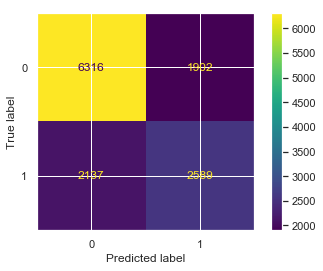

In [101]:
matrice_confusion(classification_KNN)

Ainsi, les indicateurs et notamment la mesure de précision (0.67) et la F-mesure (0.42) sont inférieurs aux indicateurs des 2 précédents modèles. La courbe ROC est nettement moins satisfaisante que les autres courbes ROC. Le Modèle KNeighbors Classifier est donc moins adapté à nos données.

### Régression logistique

In [16]:
import statsmodels as sm
from statsmodels.tools import add_constant
XTrainBis = sm.tools.add_constant(xTrain)

from statsmodels.api import Logit
#régression logistique - on passe la cible et les explicatives
modele_logistique = Logit(endog=yTrain,exog=XTrainBis).fit()

/Users/cloclo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.569682
         Iterations 6


In [17]:
print(modele_logistique.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                51772
Model:                          Logit   Df Residuals:                    51760
Method:                           MLE   Df Model:                           11
Date:                Sun, 02 Jan 2022   Pseudo R-squ.:                  0.1311
Time:                        21:19:09   Log-Likelihood:                -29494.
converged:                       True   LL-Null:                       -33942.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.2296      0.036    -61.748      0.000      -2.300      -2.159
Route dep ou nationale       0.7356      0.021     34.657      0.000       0.694       0.

On remarque que les variables "A chaussées séparées" (circ) et "Plein jour" (lum) ne sont pas significatives au seuil de 5%. On regroupe donc la modalité plein jour avec la modalité "Nuit avec éclairage public allumé" et la modalité "Chaussées Séparées" avec "A sens unique".

In [18]:
# Les variables explicatives sous forme d'indicatrices
col2 = ["Route dep ou nationale", "Sur accotement", "Autre lieu de l'accident", "Hors agglomeration",
       "Bidirectionnelle", "Nuit sans éclairage",
       "Sans collision", "Autre collision", "Courbe"]

# Créer de la base de donner avec uniquement les variables explicatives
df_temp2 = df_accidents[col2]

# Création des échantillons de test et d'apprentissage
xTrain2, xTest2, yTrain2, yTest2 = train_test_split(df_temp2, df_accidents["y"].values.ravel(), test_size = 0.2, random_state = 0)

In [19]:
modele_logistique_2 = Logit(endog=yTrain2,exog=sm.tools.add_constant(xTrain2)).fit()

Optimization terminated successfully.
         Current function value: 0.569691
         Iterations 5


#### Interprétation des coefficients :
Pour interprêter les coefficients, on utilise les odd ratios. Il y a plus de risque que l'accident soit grave s'il a lieu sur une route département ou nationale, hors agglomération, sur une route bidirectionnelle, sans éclarage.

In [20]:
model_odds = pd.DataFrame(modele_logistique_2.params, columns= ['Coefficient'])
model_odds["Odd Ratio"] = np.exp(modele_logistique_2.params)
model_odds['p-value']= modele_logistique_2.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(modele_logistique_2.conf_int())

model_odds

,Coefficient,Odd Ratio,p-value,2.5%,97.5%
const,-2.204127,0.110347,0.000000e+00,0.105236,0.115706
Route dep ou nationale,0.735244,2.085991,1.592760e-263,2.001088,2.174497
Sur accotement,0.624996,1.868238,3.823150e-47,1.716095,2.033868
Autre lieu de l'accident,0.501348,1.650946,3.319527e-35,1.524981,1.787316
Hors agglomeration,0.881570,2.414687,0.000000e+00,2.307246,2.527132
Bidirectionnelle,0.880892,2.413050,0.000000e+00,2.310026,2.520669
Nuit sans éclairage,0.263875,1.301965,8.328482e-16,1.220942,1.388366
Sans collision,0.407389,1.502889,1.101387e-29,1.400493,1.612772
Autre collision,0.513477,1.671091,3.206670e-107,1.596352,1.749328
Courbe,0.273519,1.314582,2.699425e-26,1.249806,1.382715


#### Evaluation de la performance du modele :

Modèle aléatoire : ROC AUC=0.500
Modèle : ROC AUC=0.731


/Users/cloclo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


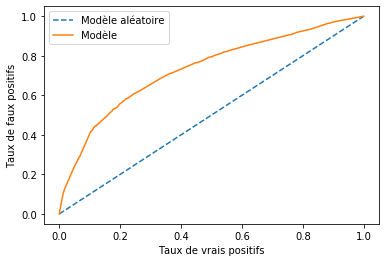

In [41]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

pred = modele_logistique_2.predict(sm.tools.add_constant(xTest2))
courbe_roc(modele_logistique_2, pred, yTest)

In [86]:
# Création de la prédiction de y
proba_pred = modele_logistique_2.predict(sm.tools.add_constant(xTest2))
pred = pd.DataFrame(proba_pred, columns = ["proba_pred"])

conditions = [pred["proba_pred"] <= 0.5, pred["proba_pred"] > 0.5]
categories = [0, 1]
pred['y_pred'] = np.select(conditions, categories)

/Users/cloclo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


La matrice de confusion est :

In [101]:
pd.crosstab(yTest,pred['y_pred'])

y_pred,0,1
row_0,,
0,7217,1001
1,2620,2106


### Arbre de décision

Dans cette partie, nous allons tester le modèle de classification par arbre de décision. Dans notre cas, les feuilles de l'arbre représentent les états de notre variable d'intéret à savoir la gravité de l'accident, il y a donc deux états possibles :
* accident grave (grave=2)
* accident peu grave (grave=1)

Les embranchements de l'arbre quant à eux correspondent à des combinaisons de nos variables d'entrées (catégorie de la route, luminosité, point de collision...). 
On utilise alors le training set pour construire l'arbre ce qui nous permet par la suite d'extrapoler le résultat de la variable sur les données de test.

In [44]:
classification_DTree = tree.DecisionTreeClassifier()
classification_DTree.fit(xTrain, yTrain)
y_pred = classification_DTree.predict(xTest)

Calcul des indicateurs


In [45]:
# Les indicateurs (cf le TP sur la classification)
sc_accuracy_DTree = sklearn.metrics.accuracy_score(y_pred, yTest)
sc_f1_DTree = sklearn.metrics.f1_score(y_pred, yTest)
sc_recall_DTree = sklearn.metrics.recall_score(y_pred, yTest)
sc_precision_DTree = sklearn.metrics.precision_score(y_pred, yTest)

In [46]:
print('accuracy : ' + str(sc_accuracy_DTree))
print('F1 score : ' + str(sc_f1_DTree))
print('Recall : ' + str(sc_recall_DTree))
print('Precision : ' + str(sc_precision_DTree))

accuracy : 0.7248145859085291
F1 score : 0.5425122013871051
Recall : 0.6901960784313725
Precision : 0.4468895471857808


Modèle aléatoire : ROC AUC=0.500
Modèle : ROC AUC=0.737


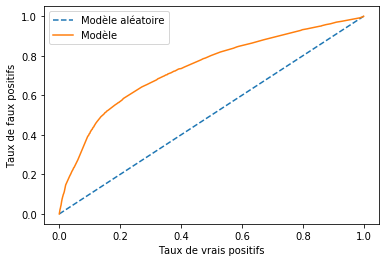

In [50]:
pred_proba = classification_DTree.predict_proba(xTest)[:, 1]
courbe_roc(classification_DTree, pred_proba, yTest)

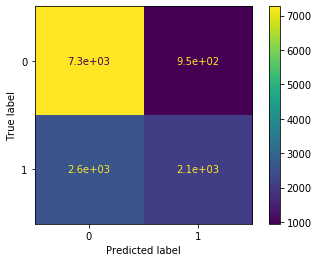

In [51]:
matrice_confusion(classification_DTree)

On obtient ainsi une Accuracy de 0.73 et un Recall de 0.68 ce qui est satisfaisant. Le Recall est particulièrement d'intéret dans notre cas car on cherche surtout à limiter les feux négatifs (ie dire qu'un accident est peu grave alors qu'en réalité il l'est) car on part du principe qu'il vaut mieux envoyer trop de secours que pas assez dans notre cas.

## Comparaison des différents modèles

On dresse un tableau récapitulatif des indicateurs obtenus lors des différents tests.

In [109]:
data = np.array([[sc_accuracy_SVC, sc_precision_SVC, sc_recall_SVC, sc_f1_SVC],
             [sc_accuracy_SGD, sc_precision_SGD, sc_recall_SGD, sc_f1_SGD],
             [sc_accuracy_KNN, sc_precision_KNN, sc_recall_KNN, sc_f1_KNN],
             [sc_accuracy_DTree, sc_precision_DTree, sc_recall_DTree, sc_f1_DTree]])
columns = ['Accuracy', 'Precision', 'Recall', 'F1']
index = ['Linear SVC', 'SGD Classifier', 'KNeighbors Classifier', 'DecisionTree Classifier']
tableau = pd.DataFrame(data=data,index=index,columns=columns)
tableau

,Accuracy,Precision,Recall,F1
Linear SVC,0.716471,0.443716,0.668260,0.533316
SGD Classifier,0.719561,0.425518,0.687286,0.525614
KNeighbors Classifier,0.687964,0.547821,0.576486,0.561788
DecisionTree Classifier,0.728059,0.457046,0.693642,0.551020


Nous superposons les courbes ROC sur un même graphe afin de déterminer le modèle le plus satisfaisant.

Modèle aléatoire : ROC AUC=0.500
Modèle SVC : ROC AUC=0.724
Modèle SGD : ROC AUC=0.725
Modèle KNN : ROC AUC=0.622
Modèle Dtree: ROC AUC=0.737


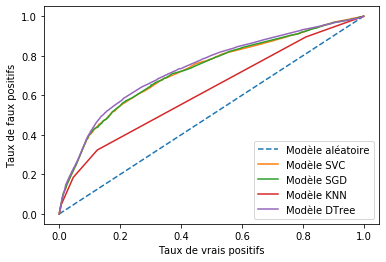

In [133]:
courbe_roc_synthese(classification_SVC, calibrated_classification_SGD, classification_KNN, classification_DTree)

/Users/cloclo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Modèle aléatoire : ROC AUC=0.500
Modèle SVC : ROC AUC=0.724
Modèle SGD : ROC AUC=0.725
Modèle KNN : ROC AUC=0.622
Modèle DTree : ROC AUC=0.737
Modèle Régression logistique : ROC AUC=0.732


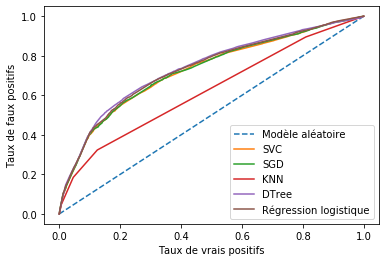

In [134]:
liste_des_modeles = [classification_SVC, calibrated_classification_SGD, classification_KNN, classification_DTree]
nom_des_modeles = ["SVC", "SGD", "KNN", "DTree"]
courbe_roc_synthese_bis(liste_des_modeles, nom_des_modeles)

En conclusion de cette partie Classification, le graphe ci-dessus nous permet de suite d'éliminer le modèle KNeighbors Classifier, mais il ne nous permet pas de départager entre le modèle Linear SVC et le modèle SGD Classifier. Le tableau récapitulatif des indicateurs de précision montre que le modèle Linear SVC a une F-mesure (0.53) un petit peu plus supérieure que celle du modèle SGD Classifier (0.52).  
Les modèles Linear SVC et SGD Classifier sont donc équivalents, 
Par ailleurs le modèle Decision Tree nous donne une meilleure accuracy, un meilleur recall et un F1 score satisfaisant. De plus la courbe ROC de ce dernier est plus satifaisante que les trois autres modèles de classification. Le modèle Decision Tree apparait donc plus plus adapté à nos données.